## Problem Defintion
Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have given a problem to identify the customers segments, those are eligible for loan amount so that they can specifically target these customers. Here they have provided a partial data set.

## Dataset
The dataset is a seconda data, which can be found on kaggle. https://www.kaggle.com/datasets/ninzaami/loan-predication


## Evaluation
If we get an accuracy score, f1 score, recall score, a good precision score between 40 and 50, then our model is ready to be in production.

## Evaluation matrics to use
* F1 Score
* Precision
* Recall
* Confusion Metrixs
* Classification

## Algorithms to experiment with
* Random Forest Classiffier
* Logist Regression
* Decision Tree
* XGBoost

## Steps
* Explore our dataset
* Preprocess our data
* Build Model
* Evaluate
* Optimize it
* Save and deploy model

In [8]:
# Setup Environment Variables
DATA_LAKE = "datalake-us-east-1-867666079941"
DATABASE_NAME = "database-us-east-1-867666079941"
DATA_WAREHOUSE = "datawarehouse-us-east-1-867666079941"
DEFUALT_DATASET_PATH_IN_S3="raw-dataset/loan-prediction.csv"

In [26]:
#Import Core Libries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import Sage Maker Libries
import sagemaker
from sagemaker import get_execution_role

# Import Other Libries
import boto3

Now that we have setup our infrastructure, we are going to start building our models by performing different experients. But before we do so, we will first bring in our dataset, explore it and get more insight from it.

In [3]:
# We are now going to bring in our dataset using boto3 but before we do that let's intialize boto3 first
s3 = boto3.client("s3")

#Initialize sagemaker
sess = sagemaker.Session()

# Get role
role = get_execution_role()

# Get bucket name for artifacts
bucket = sess.default_bucket()

#Display role and defult bucket name
print(f"Default Bucket name: {bucket}")
print(f"Default execution role: {role}")

Default Bucket name: sagemaker-us-east-1-867666079941
Default execution role: arn:aws:iam::867666079941:role/mlproject-sagemaker-iam-role


In [9]:
try:
    
    # Get dataset
    df = pd.read_csv("../data/raw/loan-prediction.csv")
    print("Dataset exists")
    
except:
    
    # Download dataset
    print("Dataset does not exists trying to download it now.....")
    
    s3.download_file(DATABASE_NAME, 
                     DEFUALT_DATASET_PATH_IN_S3, 
                     "../data/raw/loan-prediction.csv")
    df = pd.read_csv("../data/raw/loan-prediction.csv")


Dataset exists


In [7]:
#Display datasets
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


Now that we have access to our dataset, we are going to move it from the database into our datawarehouse, preprocess it and move it into our datalake.

In [15]:
# Upoad dataset into datalake
s3.upload_file("../data/raw/loan-prediction.csv", 
               DATA_LAKE, 
               DEFUALT_DATASET_PATH_IN_S3)

In [19]:
#Display the first five sample
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [20]:
# Display the last five samples
df.tail()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y
613,LP002990,Female,No,0,Graduate,Yes,4583,0.0,133.0,360.0,0.0,Semiurban,N


In [22]:
# Check if dataset is balanced
df["Loan_Status"].value_counts()

Loan_Status
Y    422
N    192
Name: count, dtype: int64

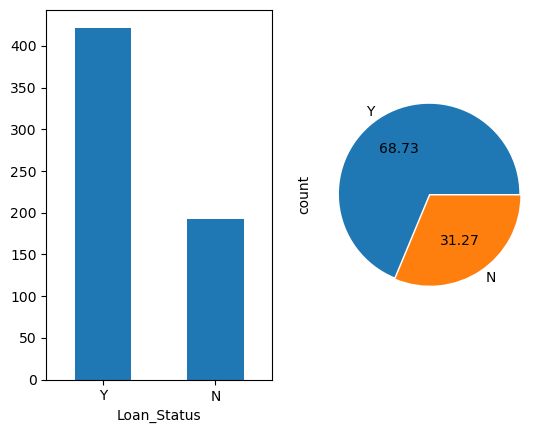

In [46]:
# Let's visualize our resuls
plt.subplot(1, 2, 1)
df["Loan_Status"].value_counts().plot(kind="bar")
plt.xticks(rotation=1)


plt.subplot(1, 2, 2)
df["Loan_Status"].value_counts().plot(kind="pie", explode=[0.01,0.01], autopct="%.2f")
plt.show()

In [47]:
# Check if null values are in dataset
df.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

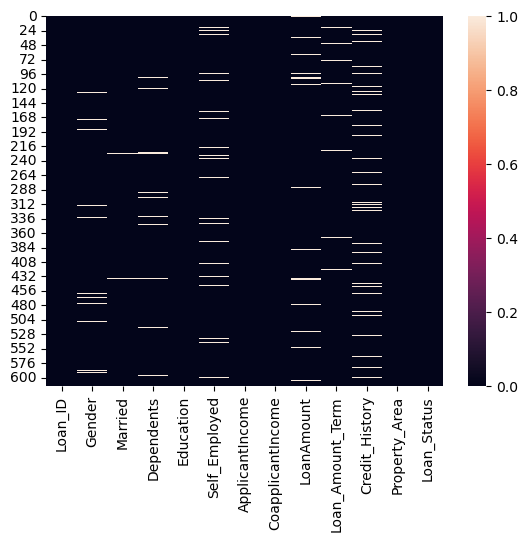

In [49]:
sns.heatmap(df.isnull())
plt.show()

<Axes: >

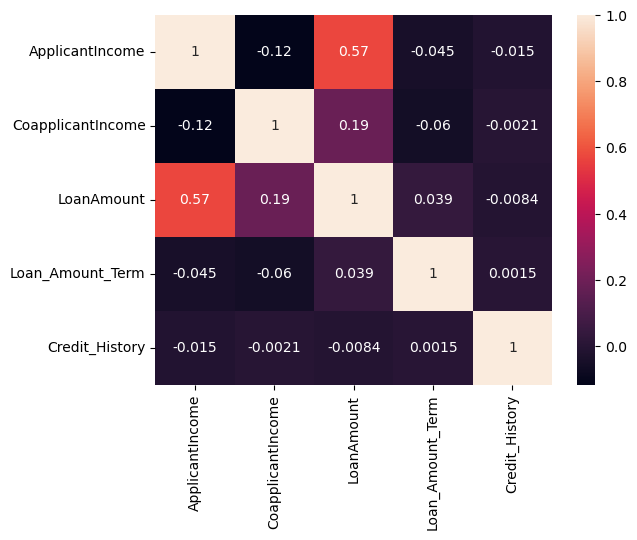

In [71]:
sns.heatmap(df.select_dtypes(exclude=["object", "category"]).corr(), annot=True)